In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

plt.style.use('seaborn-white')

In [3]:
# Leggiamo il dataframe dal file csv 'clienti.csv'
clienti = pd.read_csv('clienti.csv', sep=',', index_col='CustomerID')
clienti.head(3)

,Imax,Recency,Frequency,MonetaryValue,EntropyProducts
CustomerID,,,,,
12347,676,1,182,4310.00,4.464578
12348,1248,74,27,1437.24,2.987771
12349,630,18,72,1457.55,4.276666


In [4]:
acquisti = pd.read_csv('acquisti.csv', sep=',')
acquisti.drop(columns=['Unnamed: 0'], inplace=True)
acquisti.head(3)

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,Spending
0,536365,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,15.30
1,536365,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6,20.34
2,536365,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,22.00


In [5]:
n_days = 373 # Periodo di osservazione del dataset
spending_per_day = clienti['MonetaryValue'] / n_days
basket_per_day = clienti['Frequency'] / n_days

clienti['SpendingPerDay'] = spending_per_day
clienti['BasketPerDay'] = basket_per_day
clienti.drop(columns=['MonetaryValue', 'Frequency'], inplace=True)

In [6]:
clienti.describe()

,Imax,Recency,EntropyProducts,SpendingPerDay,BasketPerDay
count,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000
mean,360.635060,91.966698,3.428550,5.053721,0.240090
std,653.166449,100.364060,1.186899,21.887908,0.589625
min,1.000000,0.000000,0.000000,0.007775,0.002681
25%,120.000000,17.000000,2.708050,0.803391,0.045576
50%,221.500000,50.000000,3.515740,1.750054,0.107239
75%,401.250000,143.000000,4.276078,4.293532,0.260054
max,14964.000000,373.000000,7.185612,743.861716,19.576408


## Creazione dei label usando l'attributo MonetaryValue

Suddividiamo i clienti in tre gruppi distinti, in base al valore dell'attributo MonetaryValue. Se un cliente ha MonetaryValue $\leq$ 0.80 allora è considerato "low-spending", se ha 0.80 $<$ MonetaryValue $\leq$ 4.29 allora è considerato "medium-spending" altrimenti, se ha MonetaryValue $>$ 4.29 allora è considerato "high-spending".

In [7]:
# Questa funzione dato il valore di SpendingPerDay, restituisce la corrispondende etichetta
def calculate_label(m):
    if m <= 0.80:
        return 0 # low-spending
    if 0.80 < m <= 4.29:
        return 1 # medium-spending
    if m > 4.29:
        return 2 # high-spending
    
labels = clienti['SpendingPerDay'].apply(calculate_label)

In [8]:
labels.value_counts()

1    2167
2    1082
0    1075
Name: SpendingPerDay, dtype: int64

In [9]:
# Eliminiamo la colonna SpendingPerDay, in quanto utilizzata per fare binning 
clienti.drop(columns=['SpendingPerDay'], inplace=True)

In [10]:
clienti.head(3)

,Imax,Recency,EntropyProducts,BasketPerDay
CustomerID,,,,
12347,676,1,4.464578,0.487936
12348,1248,74,2.987771,0.072386
12349,630,18,4.276666,0.193029


## Creazione del Training Set e Test Set

Creiamo quattro dataframe che rappresentano il training set, il test set e i rispettivi labels.

In [11]:
train_set, test_set, train_label, test_label = train_test_split(clienti, labels, stratify=labels, test_size=0.30)

Inoltre definiamo due funzioni che ci serviranno per stampare i risultati ottenuti dalla classificazione.

## Definizione di funzioni utilità

In [12]:
# Funzioni che useremo per stampare i risultati della classificazione
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['low-spending', 'medium-spending', 'high-spending']))
    

def print_metrics(train_label, train_pred_dt, test_label, test_pred_dt):
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
    print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

# Standardizzazione del dataset

In seguito standardizziamo il dataset, che utilizzeremo se l'algoritmo di classificazione necessita di un dataset standardizzato.

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clienti_normalized = scaler.fit_transform(clienti.values)
train_set_normalized, test_set_normalized, train_label_normalized , test_label_normalized = train_test_split(clienti_normalized, labels, stratify=labels, test_size=0.30)

# Decision Tree

In [14]:
from sklearn import tree

## Grid Search per la scelta dei parametri del Decision Tree

Applichiamo la Grid Search per la scelta dei migliori parametri per il Decision Tree.

In [15]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "criterion": ['gini', 'entropy'],
    "splitter" : ['best'],
    "max_depth": [2, 4, 6, 8, 10, 12, None],
    "min_samples_split": [1, 2, 4, 6], # Non funziona se faccio come la prof, ma questi sono valori a caso
    "min_samples_leaf": [1, 2, 4, 6] # Non funziona se faccio come la prof, ma questi sono valori a caso
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = tree.DecisionTreeClassifier()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * criterion = entropy
   * max_depth = 6
   * min_samples_leaf = 4
   * min_samples_split = 2
   * splitter = best


Applichiamo il Decision Tree usando i parametri trovati e lo alleniamo sul training set.

In [16]:
decision_tree = tree.DecisionTreeClassifier()
# Usiamo i parametri trovati con la grid seatch
decision_tree.set_params(**best_params)

# Alleniamo il modello sul training set
decision_tree = decision_tree.fit(train_set, train_label)

Applichiamo il Decision Tree al training set e al test set.

In [17]:
# Labels ottenuti facendo predizione sul training set
train_prediction_decision_tree = decision_tree.predict(train_set)
# Labels ottenuti facendo predizione sul test set
test_prediction_decision_tree = decision_tree.predict(test_set)

## Evaluation: metriche e confusion matrix

In [18]:
print_metrics(train_label, train_prediction_decision_tree, test_label, test_prediction_decision_tree)

Accuracy train set  0.8122934567085262
Accuracy test set  0.773497688751926
Precision train set  0.8207411189285003
Recall train set  0.8122934567085262
F1 score train set  0.8102902970971992
Support train set  (array([0.86254296, 0.76823064, 0.88444444]), array([0.66755319, 0.89584707, 0.78863937]), array([0.75262369, 0.82714547, 0.83379888]), array([ 752, 1517,  757], dtype=int64))


In [19]:
report_scores(test_label, test_prediction_decision_tree)

                 precision    recall  f1-score   support

   low-spending       0.81      0.60      0.69       323
medium-spending       0.74      0.86      0.79       650
  high-spending       0.83      0.78      0.80       325

       accuracy                           0.77      1298
      macro avg       0.79      0.75      0.76      1298
   weighted avg       0.78      0.77      0.77      1298



Visualizziamo la Confusion Matrix.

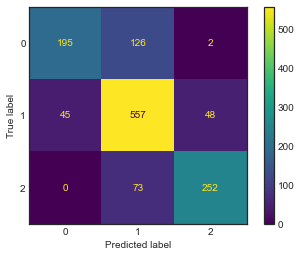

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(decision_tree, test_set, test_label)
plt.show() 

# KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

## Grid Search per la scelta dei parametri di KNN

In [22]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
# Ha senso scegliere weights, p e algorithm diversi?

dict_parametri = {
    "n_neighbors" : [2, 4, 6, 8, 10],
    "weights" : ['uniform', 'distance'], # vedi documentazione
    "algorithm" : ['ball_tree', 'kd_tree'], # Alternative: auto (sceglie lui il migliore), brute -> fa brute-force search
    "metric" : ['minkowski'], # è usata di default, lo metto per chiarezza. il tipo di distanza cambia in base al valore di p
    "p" : [1, 2], # 1 -> manhattan distance, 2 -> eclidean distance, 
    "n_jobs" : [-1] # Così usa il massimo grado di parallelismo possibile per fare KNN
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = KNeighborsClassifier()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * algorithm = ball_tree
   * metric = minkowski
   * n_jobs = -1
   * n_neighbors = 10
   * p = 1
   * weights = uniform


Applichiamo KNN usando i parametri trovati e lo alleniamo sul training set.

In [23]:
knn = KNeighborsClassifier()
# Usiamo i parametri trovati con la grid seatch
knn.set_params(**best_params)
knn.fit(train_set, train_label)

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=10, p=1)

Applichiamo il KNN al training set e al test set.

In [24]:
# Labels ottenuti facendo predizione sul test set
test_prediction_knn = knn.predict(test_set)

## Evaluation: metriche e confusion matrix

In [25]:
report_scores(test_label, test_prediction_knn)

                 precision    recall  f1-score   support

   low-spending       0.69      0.67      0.68       323
medium-spending       0.68      0.74      0.71       650
  high-spending       0.71      0.62      0.66       325

       accuracy                           0.69      1298
      macro avg       0.70      0.68      0.68      1298
   weighted avg       0.69      0.69      0.69      1298



Visualizziamo la Confusion Matrix.

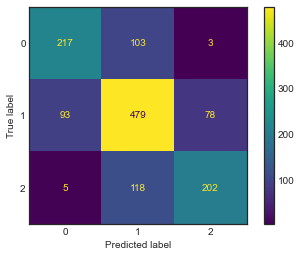

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(knn, test_set, test_label)
plt.show() 

# KNN con dataset standardizzato

In [27]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
# Ha senso scegliere weights, p e algorithm diversi?

dict_parametri = {
    "n_neighbors" : [2, 4, 6, 8, 10],
    "weights" : ['uniform', 'distance'], # vedi documentazione
    "algorithm" : ['ball_tree', 'kd_tree'], # Alternative: auto (sceglie lui il migliore), brute -> fa brute-force search
    "metric" : ['minkowski'], # è usata di default, lo metto per chiarezza. il tipo di distanza cambia in base al valore di p
    "p" : [1, 2], # 1 -> manhattan distance, 2 -> eclidean distance, 
    "n_jobs" : [-1] # Così usa il massimo grado di parallelismo possibile per fare KNN
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = KNeighborsClassifier()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set_normalized, train_label_normalized)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * algorithm = ball_tree
   * metric = minkowski
   * n_jobs = -1
   * n_neighbors = 10
   * p = 1
   * weights = distance


In [28]:
knn = KNeighborsClassifier()
# Usiamo i parametri trovati con la grid seatch
knn.set_params(**best_params)
knn.fit(train_set_normalized, train_label_normalized)

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=10, p=1,
                     weights='distance')

In [29]:
# Labels ottenuti facendo predizione sul test set
test_prediction_knn = knn.predict(test_set_normalized)

In [30]:
report_scores(test_label_normalized, test_prediction_knn)

                 precision    recall  f1-score   support

   low-spending       0.70      0.72      0.71       323
medium-spending       0.74      0.79      0.77       650
  high-spending       0.84      0.71      0.77       325

       accuracy                           0.75      1298
      macro avg       0.76      0.74      0.75      1298
   weighted avg       0.76      0.75      0.75      1298



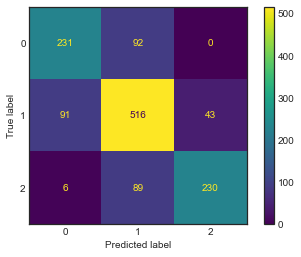

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(knn, test_set_normalized, test_label_normalized)
plt.show() 

# Naive Bayesian Classifier

Dato che il Naive Bayesian Classifier non necessita di particolari parametri, non occorre effettuale la grid search.

In [32]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
# Alleniamo il modello sul training set
gnb.fit(train_set, train_label)
# Perché qui la prof non prova a fare predizione sul training set?
# Labels ottenuti facendo predizione sul test set
test_prediction_gnb = gnb.predict(test_set)

## Evaluation: metriche e confusion matrix

In [33]:
report_scores(test_label, test_prediction_gnb)

                 precision    recall  f1-score   support

   low-spending       0.62      0.88      0.73       323
medium-spending       0.74      0.67      0.70       650
  high-spending       0.83      0.64      0.72       325

       accuracy                           0.71      1298
      macro avg       0.73      0.73      0.72      1298
   weighted avg       0.73      0.71      0.71      1298



Visualizziamo la Confusion Matrix.

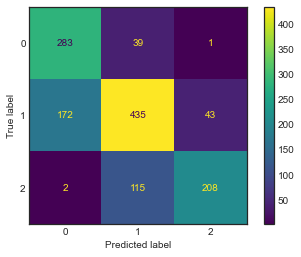

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Perché la prof la calcola se poi non la usa?
confusion_matrix = confusion_matrix(test_label, test_prediction_knn)

plot_confusion_matrix(gnb, test_set, test_label)
plt.show() 

# Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

## Grid Search per la scelta dei parametri di Random Forest

In [36]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "n_estimators" : [100],
    "criterion" : ['gini', 'entropy'],
    "max_depth": [8, 16, 32, None],
    "min_samples_split": [1, 2, 4, 6],
    "min_samples_leaf": [1, 2, 4, 6],
    "n_jobs" : [-1]
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = RandomForestClassifier()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * criterion = gini
   * max_depth = 16
   * min_samples_leaf = 4
   * min_samples_split = 6
   * n_estimators = 100
   * n_jobs = -1


Applichiamo la Random Forest usando i parametri trovati e lo alleniamo sul training set.

In [37]:
random_forest = RandomForestClassifier()
# Usiamo i parametri trovati con la grid seatch
random_forest.set_params(**best_params)

# Alleniamo il modello sul training set
random_forest = random_forest.fit(train_set, train_label)

In [38]:
# Labels ottenuti facendo predizione sul training set
train_prediction_random_forest = random_forest.predict(train_set)
# Labels ottenuti facendo predizione sul test set
test_prediction_random_forest = random_forest.predict(test_set)

## Evaluation: metriche e confusion matrix

In [39]:
print_metrics(train_label, train_prediction_random_forest, test_label, test_prediction_random_forest)

Accuracy train set  0.8949107732980833
Accuracy test set  0.8073959938366718
Precision train set  0.8956578590099167
Recall train set  0.8949107732980833
F1 score train set  0.8947636556182516
Support train set  (array([0.90469417, 0.87775677, 0.92255435]), array([0.84574468, 0.91825972, 0.89696169]), array([0.8742268 , 0.89755155, 0.90957803]), array([ 752, 1517,  757], dtype=int64))


In [40]:
report_scores(test_label, test_prediction_random_forest)

                 precision    recall  f1-score   support

   low-spending       0.76      0.72      0.74       323
medium-spending       0.81      0.82      0.81       650
  high-spending       0.86      0.88      0.87       325

       accuracy                           0.81      1298
      macro avg       0.81      0.80      0.81      1298
   weighted avg       0.81      0.81      0.81      1298



Visualizziamo la Confusion Matrix.

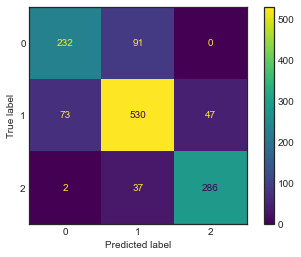

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Perché la prof la calcola se poi non la usa?
confusion_matrix = confusion_matrix(test_label, test_prediction_random_forest)

plot_confusion_matrix(random_forest, test_set, test_label)
plt.show() 

# SVM

In [42]:
from sklearn.svm import SVC

## Grid Search per la scelta dei parametri di SVM

In [43]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "C" : [1, 10, 100],
    "kernel" : ['rbf', 'sigmoid'],
    "gamma" : ['scale', 'auto']
}

# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = SVC()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * C = 100
   * gamma = scale
   * kernel = rbf


Applichiamo l'SVM usando i parametri trovati e lo alleniamo sul training set.

In [44]:
svm = SVC()
# Usiamo i parametri trovati con la grid seatch
svm.set_params(**best_params)

# Alleniamo il modello sul training set
svm = svm.fit(train_set, train_label)

In [45]:
# Labels ottenuti facendo predizione sul training set
train_prediction_svm = svm.predict(train_set)
# Labels ottenuti facendo predizione sul test set
test_prediction_svm = svm.predict(test_set)

## Evaluation: metriche e confusion matrix

In [46]:
print_metrics(train_label, train_prediction_svm, test_label, test_prediction_svm)

Accuracy train set  0.7115003304692663
Accuracy test set  0.7033898305084746
Precision train set  0.7202810715864868
Recall train set  0.7115003304692663
F1 score train set  0.7082964389697982
Support train set  (array([0.76342282, 0.67726027, 0.76363636]), array([0.60505319, 0.81476599, 0.61030383]), array([0.67507418, 0.73967684, 0.6784141 ]), array([ 752, 1517,  757], dtype=int64))


In [47]:
report_scores(test_label, test_prediction_svm)

                 precision    recall  f1-score   support

   low-spending       0.76      0.61      0.68       323
medium-spending       0.67      0.80      0.73       650
  high-spending       0.73      0.60      0.66       325

       accuracy                           0.70      1298
      macro avg       0.72      0.67      0.69      1298
   weighted avg       0.71      0.70      0.70      1298



Notiamo che le classi low-spending e high-spending hanno recall più bassa, quindi proviamo a migliorare la capacità predittiva del modello aggiungendo dei pesi alle classi.

In [48]:
class_weights = {
    0 : 0.375,
    1 : 0.25,
    2 : 0.375,
}
svm = SVC()
# Usiamo i parametri trovati con la grid seatch
svm.set_params(**best_params, class_weight=class_weights)

# Alleniamo il modello sul training set
svm = svm.fit(train_set, train_label)

In [49]:
# Labels ottenuti facendo predizione sul training set
train_prediction_svm = svm.predict(train_set)
# Labels ottenuti facendo predizione sul test set
test_prediction_svm = svm.predict(test_set)

## Evaluation SVM (pesi alle classi): metriche e confusion matrix

In [50]:
print_metrics(train_label, train_prediction_svm, test_label, test_prediction_svm)

Accuracy train set  0.7005948446794448
Accuracy test set  0.7010785824345146
Precision train set  0.7007109987307916
Recall train set  0.7005948446794448
F1 score train set  0.7005923206877983
Support train set  (array([0.69109948, 0.70718603, 0.69728331]), array([0.70212766, 0.69413316, 0.71202114]), array([0.69656992, 0.7005988 , 0.70457516]), array([ 752, 1517,  757], dtype=int64))


In [51]:
report_scores(test_label, test_prediction_svm)

                 precision    recall  f1-score   support

   low-spending       0.69      0.72      0.71       323
medium-spending       0.72      0.68      0.70       650
  high-spending       0.69      0.72      0.70       325

       accuracy                           0.70      1298
      macro avg       0.70      0.71      0.70      1298
   weighted avg       0.70      0.70      0.70      1298



Visualizziamo la Confusion Matrix.

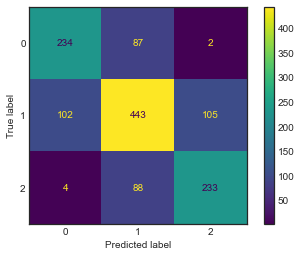

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, test_set, test_label)
plt.show() 

# SVM con dataset standardizzato

## Grid Search per la scelta dei parametri di SVM

In [53]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "C" : [1, 10, 100],
    "kernel" : ['rbf', 'sigmoid'],
    "gamma" : ['scale', 'auto']
}

# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = SVC()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set_normalized, train_label_normalized)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params_svm_1 = grid_search.best_params_

print("Migliori parametri:")
for param in best_params_svm_1:
    print("   *", param, "=", best_params_svm_1[param])

Migliori parametri:
   * C = 100
   * gamma = auto
   * kernel = rbf


Applichiamo l'SVM usando i parametri trovati e lo alleniamo sul training set.

In [54]:
svm = SVC()
# Usiamo i parametri trovati con la grid seatch
svm.set_params(**best_params_svm_1)

# Alleniamo il modello sul training set
svm = svm.fit(train_set_normalized, train_label_normalized)

In [55]:
# Labels ottenuti facendo predizione sul training set
train_prediction_svm = svm.predict(train_set_normalized)
# Labels ottenuti facendo predizione sul test set
test_prediction_svm = svm.predict(test_set_normalized)

In [56]:
print_metrics(train_label_normalized, train_prediction_svm, test_label_normalized, test_prediction_svm)

Accuracy train set  0.8132848645076008
Accuracy test set  0.8066255778120185
Precision train set  0.8146010681941279
Recall train set  0.8132848645076008
F1 score train set  0.8129978653889518
Support train set  (array([0.79340029, 0.79382716, 0.87729196]), array([0.73537234, 0.84772577, 0.82166446]), array([0.76328502, 0.81989162, 0.84856753]), array([ 752, 1517,  757], dtype=int64))


In [57]:
report_scores(test_label_normalized, test_prediction_svm)

                 precision    recall  f1-score   support

   low-spending       0.79      0.74      0.76       323
medium-spending       0.79      0.84      0.81       650
  high-spending       0.87      0.80      0.83       325

       accuracy                           0.81      1298
      macro avg       0.82      0.79      0.80      1298
   weighted avg       0.81      0.81      0.81      1298



Visualizziamo la Confusion Matrix.

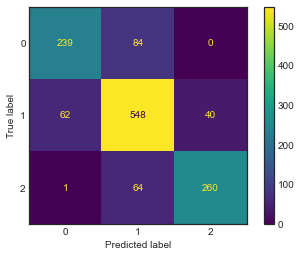

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, test_set_normalized, test_label_normalized)
plt.show() 

# SVM con dataset normalizzato (con pesi alle classi)

In [59]:
svm = SVC()
# Usiamo i parametri trovati con la grid seatch
class_weights = {
    0 : 0.375,
    1 : 0.25,
    2 : 0.375,
}
svm.set_params(**best_params, class_weight=class_weights)

# Alleniamo il modello sul training set
svm = svm.fit(train_set_normalized, train_label_normalized)

In [60]:
# Labels ottenuti facendo predizione sul training set
train_prediction_svm = svm.predict(train_set_normalized)
# Labels ottenuti facendo predizione sul test set
test_prediction_svm = svm.predict(test_set_normalized)

In [61]:
print_metrics(train_label_normalized, train_prediction_svm, test_label_normalized, test_prediction_svm)

Accuracy train set  0.7888301387970919
Accuracy test set  0.7981510015408321
Precision train set  0.7918694184614486
Recall train set  0.7888301387970919
F1 score train set  0.7892459198795523
Support train set  (array([0.70427553, 0.81104034, 0.84046693]), array([0.78856383, 0.75543837, 0.85601057]), array([0.74404015, 0.78225256, 0.84816754]), array([ 752, 1517,  757], dtype=int64))


In [62]:
report_scores(test_label_normalized, test_prediction_svm)

                 precision    recall  f1-score   support

   low-spending       0.72      0.83      0.77       323
medium-spending       0.82      0.76      0.79       650
  high-spending       0.84      0.84      0.84       325

       accuracy                           0.80      1298
      macro avg       0.79      0.81      0.80      1298
   weighted avg       0.80      0.80      0.80      1298



Visualizziamo la Confusion Matrix.

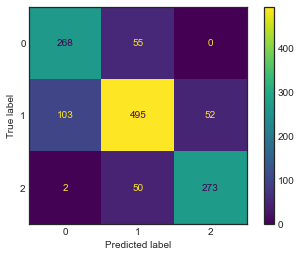

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, test_set_normalized, test_label_normalized)
plt.show() 

# MODELLO MIGLIORE: SVM (dataset standardizzato, senza pesi alle classi)

In [64]:
from sklearn.model_selection import cross_validate
import statistics
scores = cross_validate(SVC(**best_params_svm_1), clienti_normalized, labels, cv=5, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.4537317752838135
Score time  0.04158935546875
Test score  0.7999507600085635
Train score  0.8146388996118027
